# 1) Introduction to Offset Window Functions

Offset window functions provide access to individual rows within a partition and can be divided into two types:

1. one type points to another row based on the current row;

1. while the other type points to a row based on an absolute position, regardless of the current row.

To understand better the difference between the two types of offset window functions, imagine that you have just arrived at a downtown hotel and are in the mood for a cup of coffee. You decide to go out and look for the closest Starbucks. As you are walking, you come across a guy and ask him for the address of the nearest Starbucks. He could respond in two different ways:

1. By giving directions to a place based on your current location. For example, he might say, "There's a really good Starbucks, just two stores to the north of where we are right now." In this case, the directions are **relative to your current location**.

1. By giving directions to a place based on a fixed reference point, like a street or landmark. For example, he might say, "There's an awesome Starbucks at the corner of 6th and Spring Street." In this case, the directions are **independent of where you're currently located**.

Offset window functions support both types of directions, relative and absolute:

1. The `LEAD()` and `LAG()` functions come under the **relative** category since they use the positional offset from the current row.

1. The `FIRST_VALUE()`, `LAST_VALUE()`, and `NTH_VALUE()` functions belong to the **absolute** category since they use an offset from the frame boundaries, making them **independent** of the current row's position.

# 2) The LEAD() Function

The LEAD() function returns the values for a row at a specified offset **below the current row in the window partition**. The default offset is 1 if not specified. Let’s look at the function syntax before examining it in more detail.

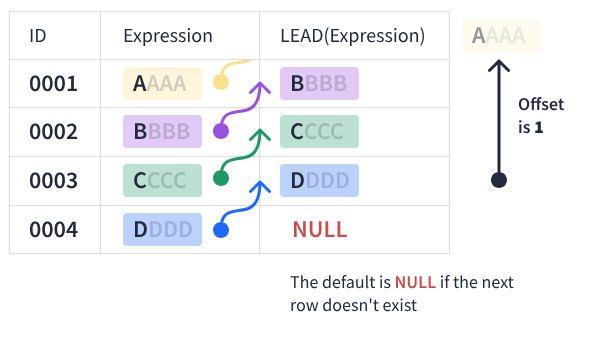

```sql
LEAD (expression, offset, default_value) 
OVER (
    [PARTITION BY partition_expression, ... ]
    ORDER BY sort_expression [ASC | DESC], ...
)
```

* `expression`: The column or expression on which the LEAD() function operates.

* `offset` (optional): A positive integer that defines the number of rows forward from the current row.

* `default_value` (optional): the value to return if the next row does not exist. The default is NULL.

* ‍`PARTITION BY‍`: an optional subclause that divides the result set into partitions based on the values of one or more columns or expressions.

* `ORDER BY`: A mandatory subclause that specifies the column or expression used to sort the rows within each partition.

The `LEAD()` function returns the column value in the row that follows the current row by the specified offset. If no such row exists, the function returns the default value, `NULL`

Notice that while the `PARTITION BY` subclause is optional — enclosed in square brackets — the `ORDER BY` subclause is **crucial** in determining the sequence of rows in the partition. It specifies the column or expression used to order the rows, making it possible to identify the previous and next rows.

Due to the nature of the `LEAD()` function, which is designed to access specific rows at a fixed offset from the current row, framing cannot be implemented in the window function. The same applies to the `LAG()` function, which we'll discuss on the next screen, as it also focuses on accessing rows at a set distance from the current row.

Consider the first five rows of the following table, `phone_sales_quantity_by_month`, containing the sales data for six months of 2022 for two brands, Samsung and Apple. The number of phone sales for each brand is given in the `quantity` column for each sales date specified in the `sales_date` column.

| sales_date | brand   | quantity |
|------------|---------|----------|
| 2022-01-31 | Apple   | 110      |
| 2022-01-31 | Samsung | 117      |
| 2022-02-28 | Samsung | 75       |
| 2022-02-28 | Apple   | 60       |
| 2022-03-31 | Apple   | 85       |

Let’s calculate the difference between the sales quantity for each brand between the **current** and **next month**.

```sql
SELECT *,
       LEAD(quantity) OVER(PARTITION BY brand
           ORDER BY sales_date) as next_month_sales,
       LEAD(quantity) OVER(PARTITION BY brand
           ORDER BY sales_date) - quantity as sales_diff
  FROM phone_sales_quantity_by_month;
```

| sales_date | brand   | quantity | next_month_sales | sales_diff |
|------------|---------|----------|------------------|------------|
| 2022-01-31 | Apple   | 110      | 60               | -50        |
| 2022-02-28 | Apple   | 60       | 85               | 25         |
| 2022-03-31 | Apple   | 85       | 134              | 49         |
| 2022-04-30 | Apple   | 134      | 90               | -44        |
| 2022-05-31 | Apple   | 90       | 100              | 10         |
| 2022-06-30 | Apple   | 100      | null             | null       |
| 2022-01-31 | Samsung | 117      | 75               | -42        |
| 2022-02-28 | Samsung | 75       | 86               | 11         |
| 2022-03-31 | Samsung | 86       | 124              | 38         |
| 2022-04-30 | Samsung | 124      | 80               | -44        |
| 2022-05-31 | Samsung | 80       | 89               | 9          |
| 2022-06-30 | Samsung | 89       | null             | null       |

The `LEAD()` function is applied over the quantity column and ordered by sales_date within each brand partition. The result of `LEAD(quantity)` returns the value of quantity in the next row within the partition. By subtracting quantity from the result of `LEAD(quantity)`, we can obtain the difference in sales quantity between the current and next month, which is aliased as `sales_diff`.

From a business perspective, analyzing the differences between sales quantities for each brand between consecutive months can provide valuable insights. Positive and increasing differences suggest a **growing sales trend**, while negative differences can raise concerns about **declining performance**.

Note that row 6 is the final row of the first partition — the Apple brand. Since there's no row past row six in the partition and next_month_sales and sales_diff are NULL for row six, there are several NULL values in the results.

## Instructions

Using the `phone_sales_quantity_by_month` table, write a query that returns the sales data for each brand and month and the percentage change in sales quantity between the current and next month.

1. Select the `brand`, `sales_date`, and `quantity` columns from the `phone_sales_quantity_by_month` table.

1. Use the `LEAD()` function, which is applied over the `quantity` column and ordered by `sales_date` within each brand partition. The result of `LEAD(quantity)` returns the value of the quantity in the next row within the partition.

    * Alias this result as `next_month_sales`.

1. Create a column called `sales_percentage_change`.

    * Subtract `quantity` from the result of `LEAD(quantity)` to obtain the difference in sales quantity between the current and next month.

    * Divide the result of the above subtraction by the current quantity and multiply it by 100 to get the sales percentage change. Use the cast operator (::) to convert the expression data type to `numeric` data type.

1. Sort the result-set based on the brand and `sales_date` columns in ascending order.

In [ ]:
%%sql
WITH n_month AS
(SELECT brand, sales_date, quantity,
       LEAD(quantity) OVER(PARTITION BY brand
                           ORDER BY sales_date) AS next_month_sales
 from phone_sales_quantity_by_month) --CTE to get next month sales for each brand
 
 
SELECT *,
       (next_month_sales - quantity)/quantity::numeric * 100 AS sales_percentage_change --convert to numeric to avoid integer division
FROM n_month
ORDER BY brand, sales_date asc 

# 3) The LAG() Function

The syntax of the `LAG()` function is the same as the `LEAD()` function; however, unlike the `LEAD()` function, it returns the value of the column from the **previous row** at a specified offset above the current row in a partition.

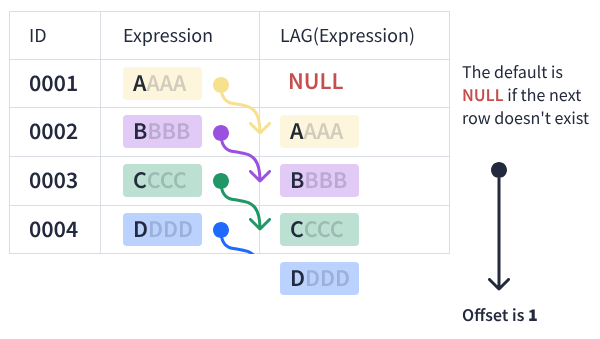

```sql
LAG (expression, offset, default_value) 
OVER (
    [PARTITION BY partition_expression, ... ]
    ORDER BY sort_expression [ASC | DESC], ...
)
```

* `expression`: The column or expression on which the LAG() function operates.

* `offset` (optional): A positive integer that defines the number of rows before the current row.

* `default_value` (optional): The value to return if the previous row does not exist. The default is NULL.

* ‍`PARTITION BY`: Optionally divides results into groups.

* `ORDER BY`: Required for sorting rows within each group.

The `LAG()` function returns the column value from a preceding row at a specified offset with a default value of NULL. While PARTITION BY is optional, the ORDER BY subclause is necessary to establish the row sequence.

Consider the `phone_sales_revenue_by_month` table containing three columns: `sales_date`, `brand`, and `revenue`.

* The `sales_date` column represents the sales data in the 'YYYY-MM-DD' format.

* The `brand` column represents the brand of the phone sold, 

* the `revenue` column represents the revenue generated by each phone brand in that specific month.

 The table contains data for six months of 2022 for two brands, Apple and Samsung.

 | sales_date | brand   | revenue  |
|------------|---------|----------|
| 2022-01-31 | Apple   | 49950.00 |
| 2022-02-28 | Apple   | 36960.00 |
| 2022-03-31 | Apple   | 24975.00 |
| 2022-04-30 | Apple   | 17970.00 |
| 2022-05-31 | Apple   | 28753.00 |
| 2022-06-30 | Apple   | 23960.00 |
| 2022-01-31 | Samsung | 48921.00 |
| 2022-02-28 | Samsung | 43200.00 |
| 2022-03-31 | Samsung | 25790.00 |
| 2022-04-30 | Samsung | 31240.00 |
| 2022-05-31 | Samsung | 70295.00 |
| 2022-06-30 | Samsung | 59821.00 |

Let's write a query based on the phone_sales_revenue_by_month table to calculate the **difference** between **each month's** sales revenue and the sales revenue from the **corresponding month in the previous quarter**.

The query allows us to compare the June 2022 revenue with the revenue from March 2022.

```sql
SELECT
    sales_date,
    brand,
    revenue,
    LAG(revenue, 3, 0.0) OVER (PARTITION BY brand ORDER BY sales_date) AS prev_quarter_revenue,
    revenue - LAG(revenue, 3, 0.0) OVER (PARTITION BY brand ORDER BY sales_date) AS difference
  FROM
    phone_sales_revenue_by_month;
```

| sales_date | brand   | revenue  | prev_quarter_revenue | difference |
|------------|---------|----------|----------------------|------------|
| 2022-01-31 | Apple   | 49950.00 | 0                    | 49950      |
| 2022-02-28 | Apple   | 36960.00 | 0                    | 36960      |
| 2022-03-31 | Apple   | 24975.00 | 0                    | 24975      |
| 2022-04-30 | Apple   | 17970.00 | 49950                | -31980     |
| 2022-05-31 | Apple   | 28753.00 | 36960                | -8207      |
| 2022-06-30 | Apple   | 23960.00 | 24975                | -1015      |
| 2022-01-31 | Samsung | 48921.00 | 0                    | 48921      |
| 2022-02-28 | Samsung | 43200.00 | 0                    | 43200      |
| 2022-03-31 | Samsung | 25790.00 | 0                    | 25790      |
| 2022-04-30 | Samsung | 31240.00 | 48921                | -17681     |
| 2022-05-31 | Samsung | 70295.00 | 43200                | 27095      |
| 2022-06-30 | Samsung | 59821.00 | 25790                | 34031      |

As we see in the query above, the `LAG()` function retrieves the previous quarter's revenue using an offset of 3. A default value of 0 is used when no data is available for the corresponding month in the previous quarter. The lagged value from the current month's revenue is subtracted to get the final result.



## Instructions

Let's assume you're working for a cell phone store that sells two popular smartphones, Apple and Samsung. One day your manager asks you to analyze monthly sales revenue changes for the two brands over six months. After investigating, you decide to use the LAG() offset window function and a CASE statement to compare sales revenue between months.

1. Write the query against the `phone_sales_revenue_by_month` table and select the `sales_date`, `brand`, and `revenue` columns.

1. Use a `CASE` statement to classify the revenue change as follows:

    * "Increase" if the current month's revenue is higher than the previous month's revenue.

    * "Decrease" if the current month's revenue is lower than the previous month's revenue.

    * "No Change" if the revenue is the same as the previous month or there is no previous month.

    * The labels should be displayed in a column called `revenue_change`.

1. Use the `LAG()` function inside the `CASE` statement to calculate the current and previous months' revenue differences.

    * Partition the data by brand.

    * Order the partitions by `sales_date`.


In [ ]:
%%sql
SELECT sales_date, brand, revenue,
       LAG(revenue) OVER(PARTITION BY brand
     ORDER BY sales_date) AS previous_moth,
       CASE
            WHEN LAG(revenue) OVER(PARTITION BY brand
     ORDER BY sales_date) < revenue  THEN 'Increase'
            WHEN LAG(revenue) OVER(PARTITION BY brand
     ORDER BY sales_date) > revenue  THEN 'Decrease'
     ELSE 'No Change'
     END AS revenue_change
FROM phone_sales_revenue_by_month

# 4) The FIRST_VALUE() Function

In the previous section, we covered the `LEAD()` and `LAG()` offset window functions, which allow us to include any column from a given number of rows away from the current row. Since these functions are relative to the current row, they're also called row offset window functions.

In contrast, the `FIRST_VALUE()`, `LAST_VALUE()`, and `NTH_VALUE()` functions are not dependent on the current row and allow us to include any column from the first, last, or nth row of the partition. These functions are also called frame offset window functions because they specify the offset with respect to the beginning or end of the window, and framing becomes relevant.

Let's get started with the `FIRST_VALUE()` function.

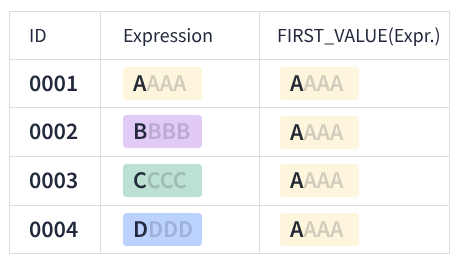

The `FIRST_VALUE()` function retrieves the value of the first row within a partition. Here's the basic syntax of the function:


```sql
FIRST_VALUE (expression)
OVER (
    [PARTITION BY partition_expression, ... ]
    ORDER BY sort_expression [ASC | DESC], ...
    [framing_clause]
)
```

Given that we've already discussed the general syntax of the offset window functions, let's shift our focus to the last part of the syntax above, `[framing_clause]`.

The `LEAD()` and `LAG()` functions support window partitioning and ordering, but not window framing. This is reasonable since the offset is relative to the current row. When using the `FIRST_VALUE()` and `LAST_VALUE()` functions, window framing comes into play because the offset is relative to the start and end of the window.

We can rely on the default framing when using the `FIRST_VALUE()` function. As we discussed in the Window Function Framing lesson when we don't explicitly indicate a window frame clause, the default framing is as follows:

`RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW`

This means that the `FIRST_VALUE()` function returns the **first row of the partition** with the default window framing.

While relying on the default framing makes sense, and the `FIRST_VALUE()` function returns a correct result, using `ROWS` instead of `RANGE` is more efficient for the database server's performance.

Now we'll explore how the `FIRST_VALUE` function works in practice.

Consider the employees table containing details of nine employees working for different departments in a company:

| employee_id | last_name | first_name | department | title               | hire_date  | salary    |
|-------------|-----------|------------|------------|---------------------|------------|-----------|
| 1           | Adams     | Andrew     | Management | General Manager     | 2002-08-13 | 108000.00 |
| 2           | Edwards   | Nancy      | Sales      | Sales Manager       | 2002-04-30 | 98900.00  |
| 3           | Peacock   | Jane       | Sales      | Sales Support Agent | 2002-03-31 | 87000.00  |
| 4           | Park      | Margaret   | Sales      | Sales Support Agent | 2003-05-02 | 69800.00  |
| 5           | Johnson   | Steve      | Sales      | Sales Support Agent | 2003-10-16 | 76500.00  |
| 6           | Mitchell  | Michael    | IT         | IT Manager          | 2003-10-16 | 89900.00  |
| 7           | King      | Robert     | IT         | IT Staff            | 2004-01-01 | 67800.00  |
| 8           | Callahan  | Laura      | IT         | IT Staff            | 2004-03-03 | 78000.00  |
| 9           | Edward    | John       | IT         | IT Staff            | 2004-09-18 | 75900.00  |

Let's assume that Adams, the company's manager, has requested a report to identify the **first hired employees in the sales and IT departments**. This report will be used to give gifts to those employees. The request can be fulfilled using the following query:

```sql
SELECT department, first_name ||' ' || last_name as full_name, hire_date,
    FIRST_VALUE(first_name ||' ' || last_name) OVER (
      PARTITION BY department
      ORDER BY hire_date
    ) AS hired_first
  FROM employees
 WHERE department IN ('Sales', 'IT');
``` 

| department | full_name        | hire_date  | hired_first      |
|------------|------------------|------------|------------------|
| IT         | Michael Mitchell | 2003-10-16 | Michael Mitchell |
| IT         | Robert King      | 2004-01-01 | Michael Mitchell |
| IT         | Laura Callahan   | 2004-03-03 | Michael Mitchell |
| IT         | John Edward      | 2004-09-18 | Michael Mitchell |
| Sales      | Jane Peacock     | 2002-03-31 | Jane Peacock     |
| Sales      | Nancy Edwards    | 2002-04-30 | Jane Peacock     |
| Sales      | Margaret Park    | 2003-05-02 | Jane Peacock     |
| Sales      | Steve Johnson    | 2003-10-16 | Jane Peacock     |

## Instructions

Write a more complicated query, including a window frame specification to return what Adams expects.

1.Create a CTE and use `FIRST_VALUE()` with a window frame specification to determine the first hire for each department ('Sales', 'IT').

Partition the data based on the `department` column and sort the data within each partition by the `hire_date` column in the `OVER()` clause.

1. Filter the results to only include employees with the first hire date for their department.

1. Return only department, full_name, and hire_date columns.

In [ ]:
%%sql
WITH first_hire_date AS
    (SELECT department, first_name ||' ' || last_name as full_name, hire_date,
     FIRST_VALUE(first_name ||' ' || last_name) OVER (
      PARTITION BY department
      ORDER BY hire_date
    ) AS hired_first
    FROM employees)
    
SELECT *
  FROM first_hire_date
  WHERE full_name = hired_first
  AND department IN ('Sales','IT')

# 5) The LAST_VALUE() Function

The `LAST_VALUE()` function retrieves the value of the last row within a partition. Here's the basic syntax of the function:

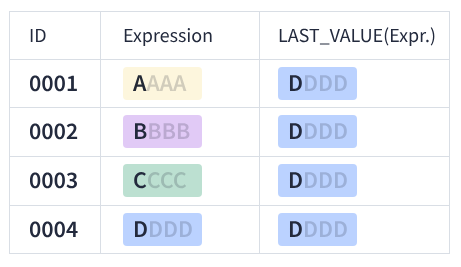

```sql
LAST_VALUE (expression)
OVER (
    [PARTITION BY partition_expression, ... ]
    ORDER BY sort_expression [ASC | DESC], ...
    [framing_clause]
)
```

However, the bad news is that with `LAST_VALUE()`, we can't rely on the default window framing since the last row of the default frame is the current row, which gives an incorrect result.

`RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW`

Let's try using the `LAST_VALUE()` function with partitioning and ordering without an explicit window frame to get the last hire date for each department for employees in the 'Sales' and 'IT' departments.

```sql
SELECT department, first_name ||' '|| last_name as full_name, hire_date,
        LAST_VALUE(hire_date) OVER (
            PARTITION BY department
            ORDER BY hire_date) AS last_hire_date
  FROM employees
 WHERE department IN ('Sales', 'IT');
 ```

 | department | full_name        | hire_date  | last_hire_date |
|------------|------------------|------------|----------------|
| IT         | Michael Mitchell | 2003-10-16 | 2003-10-16     |
| IT         | Robert King      | 2004-01-01 | 2004-01-01     |
| IT         | Laura Callahan   | 2004-03-03 | 2004-03-03     |
| IT         | John Edward      | 2004-09-18 | 2004-09-18     |
| Sales      | Jane Peacock     | 2002-03-31 | 2002-03-31     |
| Sales      | Nancy Edwards    | 2002-04-30 | 2002-04-30     |
| Sales      | Margaret Park    | 2003-05-02 | 2003-05-02     |
| Sales      | Steve Johnson    | 2003-10-16 | 2003-10-16     |

While we were expecting the query above to return every employee's department, full name, and hire date, alongside the last hire date in each department, it returns the current row's hire date in the `last_hire_date` column. 

To fix the issue, we have to use an explicit window frame specification with `UNBOUNDED FOLLOWING` as the upper boundary of the frame, as follows:

```sql
SELECT department, first_name ||' '|| last_name as full_name, hire_date,
        LAST_VALUE(hire_date) OVER (
            PARTITION BY department
            ORDER BY hire_date
            ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING) AS last_hire_date
  FROM employees
 WHERE department IN ('Sales', 'IT');
 ```

 | department | full_name        | hire_date  | last_hire_date |
|------------|------------------|------------|----------------|
| IT         | Michael Mitchell | 2003-10-16 | 2004-09-18     |
| IT         | Robert King      | 2004-01-01 | 2004-09-18     |
| IT         | Laura Callahan   | 2004-03-03 | 2004-09-18     |
| IT         | John Edward      | 2004-09-18 | 2004-09-18     |
| Sales      | Jane Peacock     | 2002-03-31 | 2003-10-16     |
| Sales      | Nancy Edwards    | 2002-04-30 | 2003-10-16     |
| Sales      | Margaret Park    | 2003-05-02 | 2003-10-16     |
| Sales      | Steve Johnson    | 2003-10-16 | 2003-10-16     |

## Instructions

Write a query against the `phone_sales_revenue_by_month` table that calculates the percentage change in revenue from each brand's first and last month of sales.

This query is among the most complex queries you've written so far. Remember, trial and error is an essential aspect of the coding process, so it's perfectly acceptable if it takes multiple attempts to succeed!

Follow the step-by-step guide to implement the query.

1. Select the `sales_date`, `brand`, and `revenue` columns from the `phone_sales_revenue_by_month` table.

1. Calculate the percentage change in revenue from each brand's first month of sales using the `FIRST_VALUE()` function.
    
    * Partition the data by `brand`.
    
    * Order the data by `sales_date` in ascending order.
    
    * Use the `ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW` to include all rows from the beginning of the partition to the current row. Calculate the percentage change as the difference between revenue and the first value of revenue in the partition, divided by the first value of revenue in the partition, multiplied by 100. Round the result to two decimal places.
    
    * Assign the result to a new column called `first_month_pct_change`.

1. Calculate the percentage change in revenue from the last month of sales for each brand using the LAST_VALUE() function.
    
    * Partition the data by `brand`.
    
    * Order the data by `sales_date` in ascending order.
    
    * Define a frame including all rows from the current row to the end of the partition.
    
    * Calculate the percentage change as the difference between revenue and the last value of revenue in the partition, divided by the last value of revenue in the partition, multiplied by 100. Round the result to two decimal places. Assign the result to a new column called last_month_pct_change.

In [ ]:
%%sql
SELECT sales_date,
       brand,
       revenue,
       --revenue - first month revenue / first month revenue * 100
       ROUND((revenue - FIRST_VALUE(revenue) OVER(
                       PARTITION BY brand
                       ORDER BY sales_date
                       ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW))/ FIRST_VALUE(revenue) OVER(
                       PARTITION BY brand
                       ORDER BY sales_date 
                       ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)*100 ,2) AS first_month_pct_change,
       
        --revenue - last month revenue / last month revenue * 100
       ROUND((revenue - LAST_VALUE(revenue) OVER(
                       PARTITION BY brand
                       ORDER BY sales_date
                       ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING))/LAST_VALUE(revenue) OVER(PARTITION BY brand
                       ORDER BY sales_date 
                       ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING)*100,2) AS last_month_pct_change
    FROM phone_sales_revenue_by_month

# 6) The NTH_VALUE() Function

The last offset window function we'll discuss is `NTH_VALUE()`.

The `NTH_VALUE()` function retrieves a value of a column or expression in a **specified offset from the first row** in the window frame.

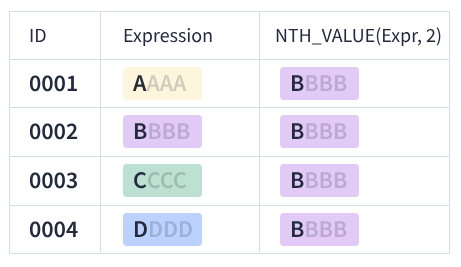

The basic syntax of the `NTH_VALUE()` function is as follows:

```sql
NTH_VALUE (expression, offset) OVER (
    [PARTITION BY partition_expression, ... ]
    ORDER BY sort_expression [ASC|DESC], ... 
    [framing_clause]
)
```

`NTH_VALUE()` takes two mandatory arguments:

* `'expression':` The column or expression on which the function operates.

* `'offset':` The position of the value to be retrieved, starting from 1.

* `PARTITION BY` partition_expression is optional and divides the dataset into partitions to which the NTH_VALUE() function is applied.

* `ORDER BY` sort_expression is mandatory and sorts the rows within each partition. If ORDER BY is omitted, the default frame consists of all rows in the partition.

* `framing_clause` is required if an ORDER BY clause is used.

To better understand how this function works, let's assume a company has been experiencing difficulties with employee retention and decided to revise the company salary structure to address the problem. They've decided to analyze the performance of employees who receive the **third highest salary in each department**. They believe the analysis result allows them to adjust and improve employee satisfaction and retention.

Our task is to write a query that retrieves the details of employees who receive the third highest salary.

We'll use a CTE to identify the third highest salary for each department and display it alongside the employee details, then filter the results to only include employees from the IT and Sales department

```sql
WITH third_highest_salary AS
    (
        SELECT department, first_name ||' '|| last_name as full_name, hire_date, salary, 
        NTH_VALUE(salary, 3) OVER (
    PARTITION BY department
    ORDER BY salary DESC
    ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
) AS third_highest_salary
FROM employees
WHERE department in ('IT','Sales')
ORDER BY department, hire_date
    )

SELECT full_name, department, hire_date, salary
FROM third_highest_salary
WHERE salary = third_highest_salary;
```
| full_name     | department | hire_date  | salary   |
|---------------|------------|------------|----------|
| John Edward   | IT         | 2004-09-18 | 75900.00 |
| Steve Johnson | Sales      | 2003-10-16 | 76500.00 |

The following expression is the core part of the above query:

```sql
NTH_VALUE(salary, 3) OVER (
    PARTITION BY department
    ORDER BY salary DESC
    ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS third_highest_salary
```

The `NTH_VALUE()` function returns the third highest salary by ordering the salaries in descending order within each department and returning the value of the third row. The `ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING` clause defines the window frame as including all rows in each department, which allows the NTH_VALUE() function to calculate the third highest salary over all rows in each department.

## Instructions

Suppose the cell phone store wants to analyze the performance of the second-best performing month for each brand.

1. Write a query against the phone_sales_revenue_by_month table that retrieves the following details for the second-best performing month for each brand in 2022:

    * `brand`

    * `sales_date`

    * `second_highest_revenue`

1. Create a common table expression (CTE).

    * Use the `NTH_VALUE()` in the SELECT statement to calculate the second-highest revenue for each brand.

    * Partition the data by `brand` and sort them by `revenue` in descending order.

    * Define a frame that includes all rows in the partition.

    * Alias the result in a column called `second_highest_revenue`.

1. Reference the CTE in the main query and filter the result set only to include the rows where the revenue equals the second-highest revenue calculated in the CTE.

In [ ]:
%%sql
WITH second_highest_rev AS (
     SELECT brand, sales_date, revenue,
            NTH_VALUE(revenue,2) OVER(PARTITION BY brand
                                      ORDER BY revenue DESC
                                      ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS second_highest_revenue
      FROM phone_sales_revenue_by_month)
    
    
SELECT *
FROM second_highest_rev
WHERE revenue = second_highest_revenue

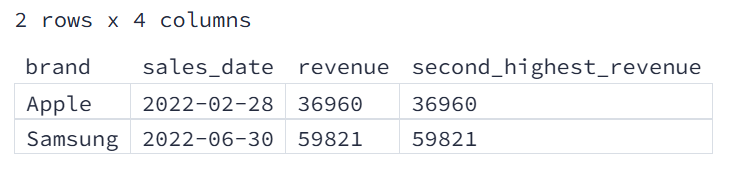

# 7) Offset Window Functions in Solving Real-World Problems

The SQL offset window functions provide powerful tools for solving real-world problems that require sequential data analysis.

## First Scenario - Anomaly Detection

The `LAG()` and `LEAD()` functions can detect anomalies in time-series financial data. Let's try them in practice.

Let's use the `LAG()` and `LEAD()` functions to detect anomalies in the cell phone sales data stored in the `phone_sales_revenue_by_month` table.

We want to detect anomalies in monthly sales data for each brand by comparing **each month's revenue with the revenue for the previous and next months**.

Anomalies in sales revenue could point to months with **significant revenue growth or decline**. Businesses can analyze the factors driving these changes and adjust their marketing strategies accordingly.

To do this, we can use the `LAG()` and `LEAD()` functions to retrieve the sales data for the previous and next months, respectively, and then compare them with the sales data for the current month. Here's the query that uses the `LAG()` and `LEAD()` functions to detect anomalies in the monthly sales data:

```sql
SELECT
  sales_date,
  brand,
  revenue,
  CASE
    WHEN revenue > LAG(revenue) OVER (PARTITION BY brand ORDER BY sales_date) * 1.4
        OR revenue > LEAD(revenue) OVER (PARTITION BY brand ORDER BY sales_date) * 1.4
    THEN 'Anomaly'
    ELSE 'Normal'
  END AS sales_status
FROM phone_sales_revenue_by_month
ORDER BY brand, sales_date;
```

| sales_date | brand   | revenue  | sales_status |
|------------|---------|----------|--------------|
| 2022-01-31 | Apple   | 49950.00 | Normal       |
| 2022-02-28 | Apple   | 36960.00 | Anomaly      |
| 2022-03-31 | Apple   | 24975.00 | Normal       |
| 2022-04-30 | Apple   | 17970.00 | Normal       |
| 2022-05-31 | Apple   | 28753.00 | Anomaly      |
| 2022-06-30 | Apple   | 23960.00 | Normal       |
| 2022-01-31 | Samsung | 48921.00 | Normal       |
| 2022-02-28 | Samsung | 43200.00 | Anomaly      |
| 2022-03-31 | Samsung | 25790.00 | Normal       |
| 2022-04-30 | Samsung | 31240.00 | Normal       |
| 2022-05-31 | Samsung | 70295.00 | Anomaly      |
| 2022-06-30 | Samsung | 59821.00 | Normal       |

The query above uses a `CASE` statement to compare the current month's revenue with the previous and next months' revenues; if the current month's revenue is forty percent higher than the previous and next months' revenues, the current month's revenue is classified as `Anomaly`; otherwise, it's classified as `Normal`.

## Instructions

The cell phone store management has defined revenue ranges as follows:

Golden Month: revenue >= 60K USD

Silver Month: 49K USD<= revenue< 60K USD

Bronze Month: 20K USD<= revenue< 49K USD

Let's assume the store manager is keen to know the **first month** each brand's revenue falls into the **silver month** range.

Write a query against the phone_sales_revenue_by_month table that addresses the request.

1. Create a Common Table Expression (CTE) to filter the table to include only rows with revenue between 49,000 USD and 60,000 USD.

    * Use the `FIRST_VALUE()` function in the CTE to determine the first month each brand's sales revenue falls within the silver range.
1. In the main query, select the `sales_date`, `brand`, and `revenue` columns from the CTE.

1. Add a condition in the WHERE clause to filter the results to show only rows where the revenue is equal to the value calculated in the CTE.